# Laboratorium

### Konfiguracja

In [1]:
# Narzędzie jest oparte o kilka zewnętrznych bibliotek, które potrzebujemy najpierw zaimportować.
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.collections as mcoll
import matplotlib.colors as mcolors
from matplotlib.widgets import Button
import json as js

# Parametr określający jak blisko (w odsetku całego widocznego zakresu) punktu początkowego 
# wielokąta musimy kliknąć, aby go zamknąć.
TOLERANCE = 0.15

def dist(point1, point2):
    return np.sqrt(np.power(point1[0] - point2[0], 2) + np.power(point1[1] - point2[1], 2))

# Klasa ta trzyma obecny stan wykresu oraz posiada metody, które mają zostać wykonane
# po naciśnięciu przycisków.
class _Button_callback(object):
    def __init__(self, scenes):
        self.i = 0
        self.scenes = scenes
        self.adding_points = False
        self.added_points = []
        self.adding_lines = False
        self.added_lines = []
        self.adding_rects = False
        self.added_rects = []

    def set_axes(self, ax):
        self.ax = ax
        
    # Metoda ta obsługuje logikę przejścia do następnej sceny.
    def next(self, event):
        self.i = (self.i + 1) % len(self.scenes)
        self.draw(autoscaling = True)

    # Metoda ta obsługuje logikę powrotu do poprzedniej sceny.
    def prev(self, event):
        self.i = (self.i - 1) % len(self.scenes)
        self.draw(autoscaling = True)
        
    # Metoda ta aktywuje funkcję rysowania punktów wyłączając równocześnie rysowanie 
    # odcinków i wielokątów.
    def add_point(self, event):
        self.adding_points = not self.adding_points
        self.new_line_point = None
        if self.adding_points:
            self.adding_lines = False
            self.adding_rects = False
            self.added_points.append(PointsCollection([]))
            
    # Metoda ta aktywuje funkcję rysowania odcinków wyłączając równocześnie
    # rysowanie punktów i wielokątów.     
    def add_line(self, event):   
        self.adding_lines = not self.adding_lines
        self.new_line_point = None
        if self.adding_lines:
            self.adding_points = False
            self.adding_rects = False
            self.added_lines.append(LinesCollection([]))

    # Metoda ta aktywuje funkcję rysowania wielokątów wyłączając równocześnie
    # rysowanie punktów i odcinków.
    def add_rect(self, event):
        self.adding_rects = not self.adding_rects
        self.new_line_point = None
        if self.adding_rects:
            self.adding_points = False
            self.adding_lines = False
            self.new_rect()
    
    def new_rect(self):
        self.added_rects.append(LinesCollection([]))
        self.rect_points = []
        
    # Metoda odpowiedzialna za właściwą logikę rysowania nowych elementów. W
    # zależności od włączonego trybu dodaje nowe punkty, początek, koniec odcinka
    # lub poszczególne wierzchołki wielokąta. Istnieje ciekawa logika sprawdzania
    # czy dany punkt jest domykający dla danego wielokąta. Polega ona na tym, że
    # sprawdzamy czy odległość nowego punktu od początkowego jest większa od
    # średniej długości zakresu pomnożonej razy parametr TOLERANCE.   
    def on_click(self, event):
        if event.inaxes != self.ax:
            return
        new_point = (event.xdata, event.ydata)
        if self.adding_points:
            self.added_points[-1].add_points([new_point])
            self.draw(autoscaling = False)
        elif self.adding_lines:
            if self.new_line_point is not None:
                self.added_lines[-1].add([self.new_line_point, new_point])
                self.new_line_point = None
                self.draw(autoscaling = False)
            else:
                self.new_line_point = new_point
        elif self.adding_rects:
            if len(self.rect_points) == 0:
                self.rect_points.append(new_point)
            elif len(self.rect_points) == 1:
                self.added_rects[-1].add([self.rect_points[-1], new_point])
                self.rect_points.append(new_point)
                self.draw(autoscaling = False)
            elif len(self.rect_points) > 1:
                if dist(self.rect_points[0], new_point) < (np.mean([self.ax.get_xlim(), self.ax.get_ylim()])*TOLERANCE):
                    self.added_rects[-1].add([self.rect_points[-1], self.rect_points[0]])
                    self.new_rect()
                else:    
                    self.added_rects[-1].add([self.rect_points[-1], new_point])
                    self.rect_points.append(new_point)
                self.draw(autoscaling = False)
    
    # Metoda odpowiedzialna za narysowanie całego wykresu. Warto zauważyć,
    # że zaczyna się ona od wyczyszczenia jego wcześniejszego stanu. Istnieje w
    # niej nietrywialna logika zarządzania zakresem wykresu, tak żeby, w zależności
    # od ustawionego parametru autoscaling, uniknąć sytuacji, kiedy dodawanie
    # nowych punktów przy brzegu obecnie widzianego zakresu powoduje niekorzystne
    # przeskalowanie.
    def draw(self, autoscaling = True):
        if not autoscaling:
            xlim = self.ax.get_xlim()
            ylim = self.ax.get_ylim()
        self.ax.clear()
        for collection in (self.scenes[self.i].points + self.added_points):
            if len(collection.points) > 0:
                self.ax.scatter(*zip(*(np.array(collection.points))), **collection.kwargs)
        for collection in (self.scenes[self.i].lines + self.added_lines + self.added_rects):
            self.ax.add_collection(collection.get_collection())
        self.ax.autoscale(autoscaling)
        if not autoscaling:
            self.ax.set_xlim(xlim)
            self.ax.set_ylim(ylim)
        plt.draw()


### Interfejsy

[Dostępne kolory](https://matplotlib.org/3.1.1/gallery/color/named_colors.html)

[Dostępne znaczniki punktów](https://matplotlib.org/3.1.1/api/markers_api.html#module-matplotlib.markers)

In [2]:
# Klasa Scene odpowiada za przechowywanie elementów, które mają być
# wyświetlane równocześnie. Konkretnie jest to lista PointsCollection i
# LinesCollection.
class Scene:
    def __init__(self, points=[], lines=[]):
        self.points=points
        self.lines=lines

# Klasa PointsCollection gromadzi w sobie punkty jednego typu, a więc takie,
# które zostaną narysowane w takim samym kolorze i stylu. W konstruktorze
# przyjmuje listę punktów rozumianych jako pary współrzędnych (x, y). Parametr
# kwargs jest przekazywany do wywołania funkcji z biblioteki MatPlotLib przez
# co użytkownik może podawać wszystkie parametry tam zaproponowane.        
class PointsCollection:
    def __init__(self, points, **kwargs):
        self.points = points
        self.kwargs = kwargs
    
    def add_points(self, points):
        self.points = self.points + points

# Klasa LinesCollection podobnie jak jej punktowy odpowiednik gromadzi
# odcinki tego samego typu. Tworząc ją należy podać listę linii, gdzie każda
# z nich jest dwuelementową listą punktów – par (x, y). Parametr kwargs jest
# przekazywany do wywołania funkcji z biblioteki MatPlotLib przez co użytkownik
# może podawać wszystkie parametry tam zaproponowane.
class LinesCollection:
    def __init__(self, lines, **kwargs):
        self.lines = lines
        self.kwargs = kwargs
        
    def add(self, line):
        self.lines.append(line)
        
    def get_collection(self):
        return mcoll.LineCollection(self.lines, **self.kwargs)

# Klasa Plot jest najważniejszą klasą w całym programie, ponieważ agreguje
# wszystkie przygotowane sceny, odpowiada za stworzenie wykresu i przechowuje
# referencje na przyciski, dzięki czemu nie będą one skasowane podczas tzw.
# garbage collectingu.
class Plot:
    def __init__(self, scenes = [Scene()], points = [], lines = [], json = None):
        if json is None:
            self.scenes = scenes
            if points or lines:
                self.scenes[0].points = points
                self.scenes[0].lines = lines
        else:
            self.scenes = [Scene([PointsCollection(pointsCol) for pointsCol in scene["points"]], 
                                 [LinesCollection(linesCol) for linesCol in scene["lines"]]) 
                           for scene in js.loads(json)]
    
    # Ta metoda ma szczególne znaczenie, ponieważ konfiguruje przyciski i
    # wykonuje tym samym dość skomplikowaną logikę. Zauważmy, że konfigurując każdy
    # przycisk podajemy referencję na metodę obiektu _Button_callback, która
    # zostanie wykonana w momencie naciśnięcia.
    def __configure_buttons(self):
        plt.subplots_adjust(bottom=0.2)
        ax_prev = plt.axes([0.6, 0.05, 0.15, 0.075])
        ax_next = plt.axes([0.76, 0.05, 0.15, 0.075])
        ax_add_point = plt.axes([0.44, 0.05, 0.15, 0.075])
        ax_add_line = plt.axes([0.28, 0.05, 0.15, 0.075])
        ax_add_rect = plt.axes([0.12, 0.05, 0.15, 0.075])
        b_next = Button(ax_next, 'Następny')
        b_next.on_clicked(self.callback.next)
        b_prev = Button(ax_prev, 'Poprzedni')
        b_prev.on_clicked(self.callback.prev)
        b_add_point = Button(ax_add_point, 'Dodaj punkt')
        b_add_point.on_clicked(self.callback.add_point)
        b_add_line = Button(ax_add_line, 'Dodaj linię')
        b_add_line.on_clicked(self.callback.add_line)
        b_add_rect = Button(ax_add_rect, 'Dodaj figurę')
        b_add_rect.on_clicked(self.callback.add_rect)
        return [b_prev, b_next, b_add_point, b_add_line, b_add_rect]
    
    def add_scene(self, scene):
        self.scenes.append(scene)
    
    def add_scenes(self, scenes):
        self.scenes = self.scenes + scenes

    # Metoda toJson() odpowiada za zapisanie stanu obiektu do ciągu znaków w
    # formacie JSON.
    def toJson(self):
        return js.dumps([{"points": [np.array(pointCol.points).tolist() for pointCol in scene.points], 
                          "lines":[linesCol.lines for linesCol in scene.lines]} 
                         for scene in self.scenes])    
    
    # Metoda ta zwraca punkty dodane w trakcie rysowania.
    def get_added_points(self):
        if self.callback:
            return self.callback.added_points
        else:
            return None
    
    # Metoda ta zwraca odcinki dodane w trakcie rysowania.
    def get_added_lines(self):
        if self.callback:
            return self.callback.added_lines
        else:
            return None
        
    # Metoda ta zwraca wielokąty dodane w trakcie rysowania.
    def get_added_figure(self):
        if self.callback:
            return self.callback.added_rects
        else:
            return None
    
    # Metoda ta zwraca punkty, odcinki i wielokąty dodane w trakcie rysowania
    # jako scenę.
    def get_added_elements(self):
        if self.callback:
            return Scene(self.callback.added_points, self.callback.added_lines+self.callback.added_rects)
        else:
            return None
    
    # Główna metoda inicjalizująca wyświetlanie wykresu.
    def draw(self):
        plt.close()
        fig = plt.figure()
        self.callback = _Button_callback(self.scenes)
        self.widgets = self.__configure_buttons()
        ax = plt.axes(autoscale_on = False)
        self.callback.set_axes(ax)
        fig.canvas.mpl_connect('button_press_event', self.callback.on_click)
        plt.show()
        self.callback.draw()
        

### Przykłady użycia

##### Proste rysowanie

Rysowanie prostego rysunku złożonego ze statycznych punktów i odcinków jest stosunkowo proste. Należy utworzyć zmienną z obiektem `Plot`, który przyjmuje w konstruktorze listę obiektów `PointsCollection` jako parametr `points` oraz listę `LinesCollection` jako parametr `lines`. Następnie należy wywołać jego metodę `draw()`.

<IPython.core.display.Javascript object>


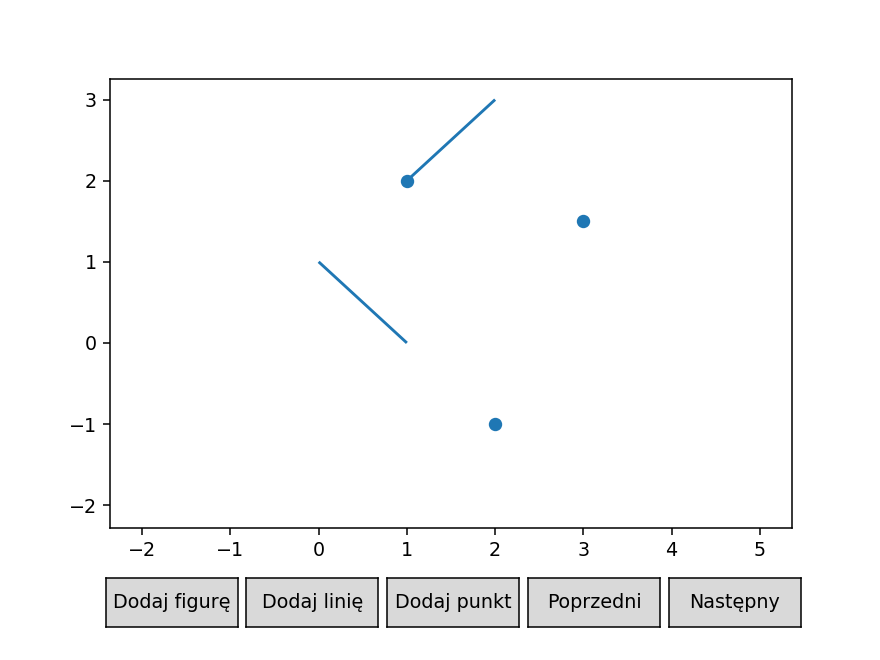

In [13]:
%matplotlib notebook

plot = Plot(points=[PointsCollection([(1, 2), (3, 1.5), (2, -1)]),
               PointsCollection([(5, -2), (2, 2), (-2, -1)], color='white', marker = "^")],
            lines=[LinesCollection([[(1,2),(2,3)], [(0,1),(1,0)]])])
plot.draw()

##### Rysunek dynamiczny

To narzędzie pozwala na wizualizację "rysunków dynamicznych", a więc takich, które składają się z wielu różnych obrazów. Może to być przydatne np. podczas wizualizacji kolejnych kroków danego algorytmu. Poszczególne klatki określane są jako obiekty `Scene`, które przyjmują listę `PointsCollection` oraz listę `LinesCollection` w swoim konstruktorze. Obiekt `Plot` przyjmuje w parametrze konstruktora `scenes` właśnie listę takich scen.

Na rysunku przyciski `Następny` i `Poprzedni` służą do nawigacji pomiędzy nimi.

<IPython.core.display.Javascript object>


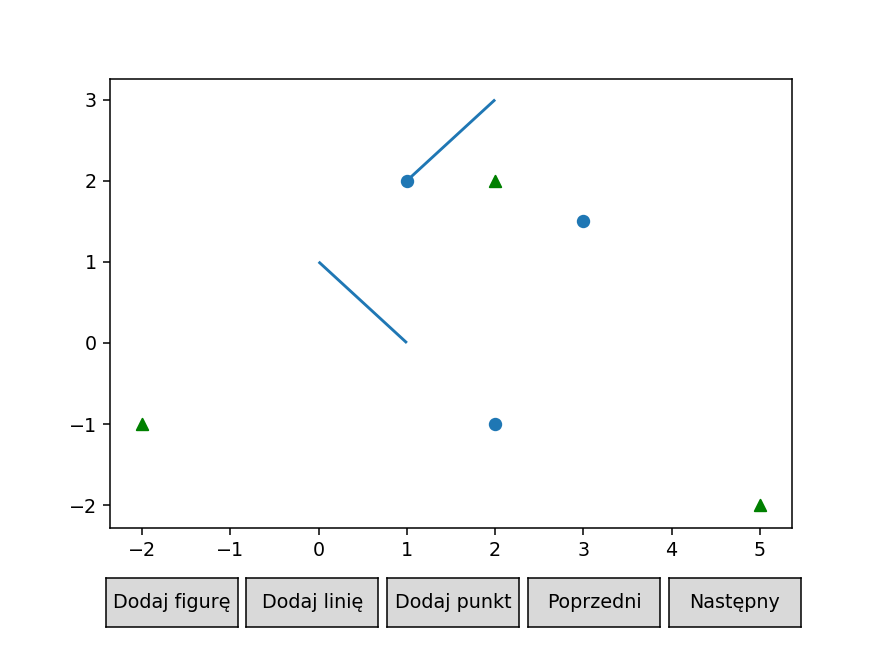

In [14]:
%matplotlib notebook

scenes=[Scene([PointsCollection([(1, 2), (3, 1.5), (2, -1)]), 
               PointsCollection([(5, -2), (2, 2), (-2, -1)], color='green', marker = "^")], 
              [LinesCollection([[(1,2),(2,3)], [(0,1),(1,0)]])]), 
        Scene([PointsCollection([(1, 2), (3, 1.5), (2, -1)], color='red'), 
               PointsCollection([(5, -2), (2, 2), (-2, 1)], color='black')], 
              [LinesCollection([[(-1,2),(-2,3)], [(0,-1),(-1,0)]])])]

plot=Plot(scenes = scenes)
plot.draw() 


###### Zapis i odczyt z pliku

Klasa Plot posiada metodę `toJson()`, która zwraca string zawierający listę scen w formacie JSON. Taki string można normalnie zapisać do pliku stosując normalne sposoby dostępne w Pythonie. Wczytanie listy scen z pliku dokonuje się poprzez podanie parametru `json` w kostruktorze `Plot`.

<IPython.core.display.Javascript object>


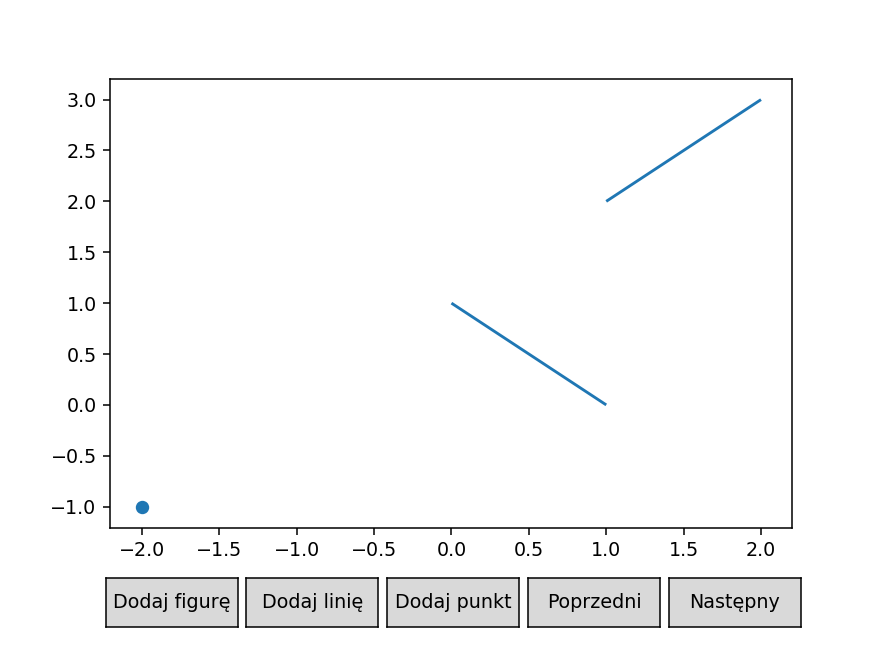

In [15]:
scenes=[Scene([PointsCollection([(-2, -1)], color='green', marker = "^")], 
              [LinesCollection([[(1,2),(2,3)], [(0,1),(1,0)]])]), 
        Scene([PointsCollection([(1, 2), (3, 1.5)], color='red'), 
               PointsCollection([(5, -2)], color='black')])]
plot = Plot(scenes)

with open('somefile.json', 'w') as file:
    file.write(plot.toJson())
    
#somefile.json: [{"points": [[[-2, -1]]], "lines": [[[[1, 2], [2, 3]], [[0, 1], [1, 0]]]]}, {"points": [[[1.0, 2.0], [3.0, 1.5]], [[5, -2]]], "lines": []}]
    
with open('somefile.json', 'r') as file:
    json = file.read()
    
plot2 = Plot(json=json)
plot2.draw()

##### Operowanie na dodanych punktach

Możemy bardzo łatwo rysować nowe punkty i linie. Aby je później wykorzystać sugerowanym sposobem jest utworzenie nowej komórki, w której utworzymy nowy `Plot` i skorzystamy z metod `get_added_points()` i `get_added_points()` lub `get_added_elements()` (zwraca scenę) z pierwszego `Plot`u.

<IPython.core.display.Javascript object>


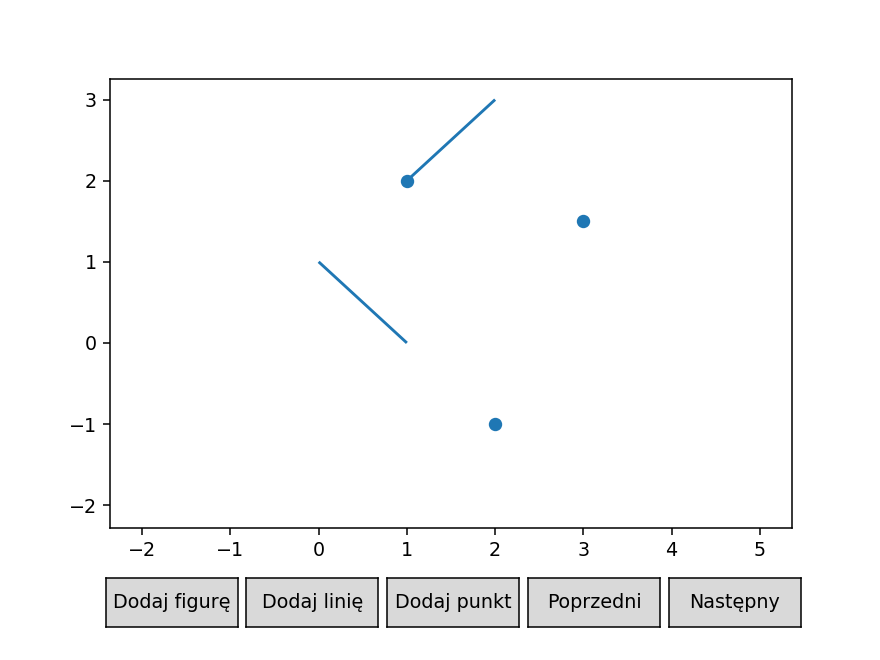

In [40]:
#Dodaj tu punkty, figury i/lub odcinki!
plot1 = Plot()
plot1.draw()

<IPython.core.display.Javascript object>


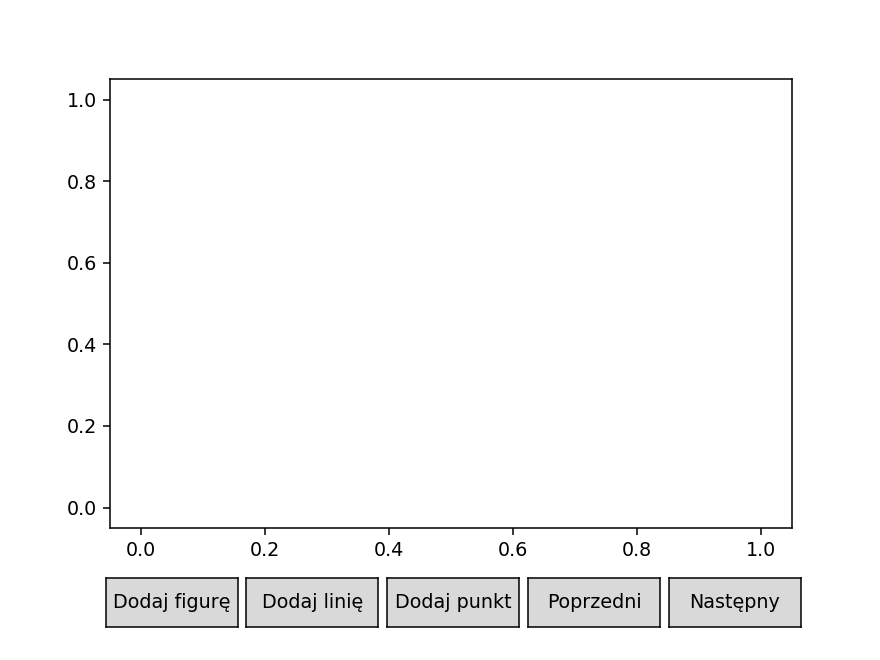

In [41]:
plot2 = Plot([plot1.get_added_elements()])
plot2.draw()

### Rozwiązanie

<IPython.core.display.Javascript object>


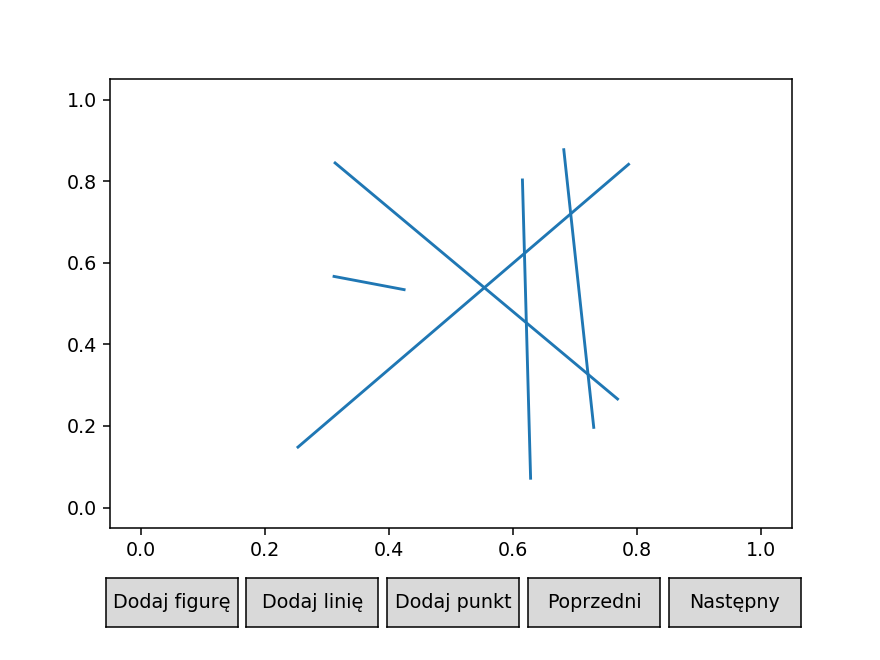

In [3]:
%matplotlib notebook
#procedura rysowania odcinkow
plottest = Plot()
plottest.draw()


<IPython.core.display.Javascript object>


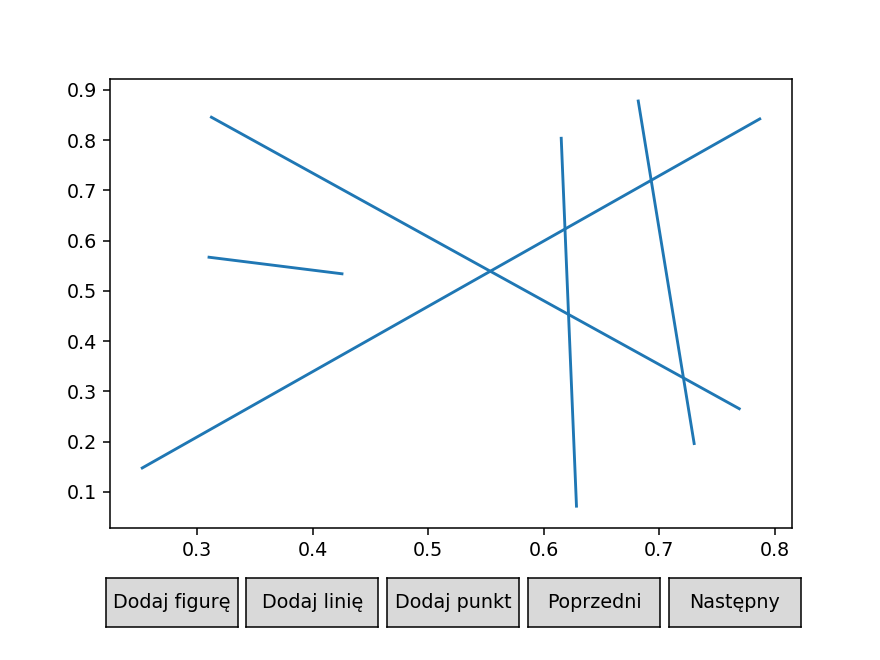

In [4]:
plot2 = Plot([plottest.get_added_elements()])
#sciagamy informacje z narysowanych linii

#zapis do pliku linie.json
with open('linie.json', 'w') as file:
    file.write(plot2.toJson())

with open('linie.json', 'r') as file:
    json = file.read()
    
plot3 = Plot(json=json)
plot3.draw() #otrzymujemy linie

In [5]:
#Wyznacznik
def cross_prod(a,b,c):
    [ax,ay] = a
    [bx,by] = b
    [cx,cy] = c
    
    det = (ax*by + bx*cy + ay*cx) - (by*cx + ay*bx + cy*ax)
    
    return det

epsilon = 10**(-10)  #dokladnosc zera

#okreslanie orientacji punktu wzgledem prostej na podstawie wyznacznika
def orientation(a,b,c):
    det = cross_prod(a,b,c)
    if det > epsilon:
        return 1
    elif det < epsilon:
        return -1
    else:
        return 0

#okreslanie wspolczynnika kierunkowego prostej, na ktorej lezy odcinek
def get_slope(line):
    return (line[1][1] - line[0][1]) / (line[1][0] - line[0][0])


#okreslenie wyrazu wolnego prostej
def get_y_intercept(line,slope):
    return line[0][1] - slope * line[0][0]


In [6]:
#wyciagamy linie z wykresu
def getting_lines_from_plot(plot):
    lines = plot.get_added_lines()
    res = []
    for i in lines:
        res = res + i.lines
    a = list(map(sorted, res))
    
    for i in range(len(a)):
        a[i] = (a[i][0],a[i][1])
    
    return a

In [7]:
#wyciaganie punktow z linii
def getting_points_from_lines(lines):
    points = []
    for line in lines:
        points.append(line[0])
        points.append(line[1])
        
    #sortujemy po wspolrzednej x
    points = sorted(points, key = lambda point : point[0])
    return points

In [8]:
#Generowanie losowych odcinkow o podanej liczbie n oraz zakresie wspolrzednych
import random

n = 8 #liczba generowanych odcinkow
x_range = [0,100] #zakres generowania x
y_range = [0,100] #zakres generowania y

def get_slope(line):
    return (line[1][1] - line[0][1]) / (line[1][0] - line[0][0])

epsilon = 10**(-10)


def generate_random_lines(n,x_range, y_range):
    
    lines = []
    slopes = set() #zbior wspolczynnikow kierunkowych, pozwoli na sprawdzenie w czasie stalym czy w liscie mamy juz odcinek,
                #ktory ma ten sam wspolczynnik kierunkowy
    pairs = set()  #tak jak wyzej, tylko zapewni nam to, aby nie bylo takich 2 takich linii,
                #ktore zaczynaja sie i koncza w tym samych x
    
    for i in range (n):
        point_not_added = True #pomocnicza flaga, aby linii rownoleglych do osi y
        
        while(point_not_added):
    
            x1 = random.uniform(x_range[0],x_range[1])
            y1 = random.uniform(y_range[0],y_range[1])
            
            x2 = random.uniform(x_range[0],x_range[1])
            y2 = random.uniform(y_range[0],y_range[1])
           
            if (x1 > x2+epsilon or x1 < x2-epsilon): #jezeli linia nie jest wzdluz osi y  
                if(x1 < x2):
                    slope = get_slope([(x1,y1),(x2,y2)])
                    pair = (x1,x2)
                    if (slope not in slopes) and (pair not in pairs):
                        lines.append(tuple([(x1,y1),(x2,y2)])) 
                        slopes.add(slope)
                        pairs.add(pair)
                        point_not_added = False
                else:
                    slope = get_slope([(x1,y1),(x2,y2)])
                    pair = (x1,x2)
                    if (slope not in slopes) and (pair not in pairs):
                        lines.append(tuple([(x2,y2),(x1,y1)]))
                        slopes.add(slope)
                        pairs.add(pair)
                        point_not_added = False
                
                
    return lines

<IPython.core.display.Javascript object>


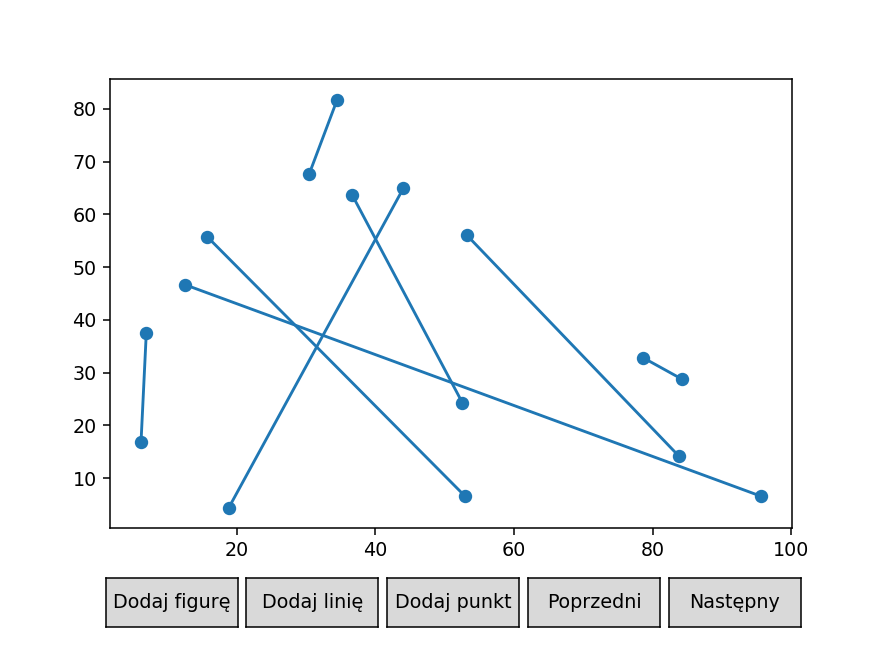

In [22]:
#Rysujemy wygenerowany zbior odcinkow
lines = generate_random_lines(n,x_range, y_range)
points =  getting_points_from_lines(lines)

plotel = Plot([Scene([PointsCollection(points)], 
              [LinesCollection(lines)])])
                  
plotel.draw()

In [23]:
%matplotlib notebook
#znajdowanie pojedynczego przecięcia

#do przechowywania stuktury zdarzen - kopiec minimum, porzadkowany po x zdarzen-punktow
#do przechowywania struktury odcinkow zamiatanych - uporzadkowany zbior, porzadkujemy po y punktow poczatkowych odcinkow

import heapq
from sortedcontainers import SortedSet


class SweepStatus:
    def __init__(self,lines,broom_range):
        self.scenes = []
        self.lines = lines
        self.points = getting_points_from_lines(lines)
        self.events = []
        self.sweeping_lines = SortedSet(key=lambda line: -line[0]) #porzadkujemy linie aktualnie rozpatrywane po y
        self.broom_range = broom_range
        self.dict_helper = {}
    
    def make_heap(self):
        #struktura do przechowywania zdarzen - kopiec minimum
        #na szczycie kopca zawsze znajduje sie zdarzenie o najmniejszej wspolrzednej x
        #zdarzenie przechowuje wspolrzedne punktu oraz dodatkowe informacje w postaci odcinka, na ktorym jest zdarzenie
        for line in self.lines:
            self.events.append([line[0],line,-1])
            self.events.append([line[1],line,1])
          
        heapq.heapify(self.events)
            
    def have_intersection(self,line1,line2):
        #funkcja do sprawdzania czy istnieje przeciecie odcinkow
        #zakladamy, ze odcinki sa aktualnie rozpatrywane, czyli maja jakis wspolny zakres x, w ktorym oba istnieja
        #wystarczy wiec sprawdzac czy oba punkty tworzace odcinek znajduja sie po jednej stronie odcinka drugiego
        (x,y) = self.get_intersection(line1,line2)
        
        return (orientation(line1[0], line1[1], line2[0]) != orientation(line1[0], line1[1], line2[1])) and (orientation(line2[0], line2[1], line1[0]) != orientation(line2[0], line2[1], line1[1])) and x>=line1[0][0] and x<=line1[1][0]
        
    def get_intersection(self,line1,line2):
        #funckja zwraca wspolrzedne punktu przeciecia
        
        a1 = get_slope(line1)
        b1 = get_y_intercept(line1,a1)
        
        a2 = get_slope(line2)
        b2 = get_y_intercept(line2,a2)     
    
        x = (-(b1-b2))/(a1-a2)
        y = a1*x +b1
        
        return (x,y)
        
        
    def sweep(self):
        flag = False
        while len(self.events) > 0:
            event = heapq.heappop(self.events)
            flag,point = self.event_happened(event)
                
            if(flag):
                print("Linie sie przecinaja, punkt znaleziony:  ", point)
                self.scenes.append(Scene([PointsCollection([point],color='red')],
                      [LinesCollection(lines,color='black')]))
                return
            
        print("Linie sie nie przecinaja")
    
    def event_happened(self,event):
        #natrafilismy miotla na zdarzenie
        self.get_scene(event)
        
        #jesli to punkt poczatkowy odcinka to dodajemy go do aktualnie rozpatrywanych --add_line
        #event[0] - punkt zdarzenia
        #event[1] - linia do ktorej nalezy zdarzenie
    
        if(event[2] == -1):
            return self.add_line(event[1])
        else: 
            #jesli to punkt koncowy to usuwamy linie z aktualnie rozpatrywanych --remove_line
            return self.remove_line(event[1])
        
      
    def add_line(self,line):
        
        #dodajemy do zbioru linii
        self.dict_helper[line] = line[0][1]
        self.sweeping_lines.add((self.dict_helper[line],line))
        self.update_keys(line[0][0])

        
        #sprawdzamy przeciecia z sasiadami
        
        index = self.sweeping_lines.index((self.dict_helper[line],line)) #odczytujemy index linii
        
        
        #sasiad gorny to index+1, jezeli istnieje
        if(index+1 < len(self.sweeping_lines)):
            if(self.have_intersection(line,self.sweeping_lines[index+1][1])): #jesli znalezlismy przeciecie to konczymy
                return True, self.get_intersection(line,self.sweeping_lines[index+1][1])
               
        #sasiad dolny index-1
        if(index-1 >= 0):
            if(self.have_intersection(line,self.sweeping_lines[index-1][1])):
                return True, self.get_intersection(line,self.sweeping_lines[index-1][1])
            
        return False,None #nie znalezlismy przeciecia w tej akcji
    
    def update_keys(self,x):
        new_sweeping_lines = SortedSet(key=lambda line: -line[0])
        
        for line in self.sweeping_lines:
            new_y = self.update(line[1],x)
            new_sweeping_lines.add((new_y,line[1]))
            self.dict_helper[line[1]] = new_y
        
        self.sweeping_lines = new_sweeping_lines
            
    def update(self,line,x):
        a = get_slope(line)
        b = get_y_intercept(line,a)
        return a*x+b
        
        
    def remove_line(self,line):
        
        index = self.sweeping_lines.index((self.dict_helper[line],line))

        
        #jesli mamy sasiada gornego oraz dolnego sprawdzamy ich przeciecie
        #jesli odcinek byl na brzegu zbioru to brak sasiadow
        
        if not (index == 0 or index == len(self.sweeping_lines)-1):
            if(self.have_intersection(self.sweeping_lines[index-1][1],self.sweeping_lines[index+1][1])):
                return True, self.get_intersection(self.sweeping_lines[index-1][1],self.sweeping_lines[index+1][1])
               
        #usuwamy linie ze zbioru skoro trafilismy na jej koniec
        self.update_keys(line[1][0])
        self.sweeping_lines.remove((self.dict_helper[line],line))
        return False, None #nie znalezlismy przeciecia
    
    def get_scene(self,event):
        point = event[0]
        line = [event[1][0],event[1][1]]
        broom = [(point[0],self.broom_range[0]),(point[0],self.broom_range[1])]
        
        scene = Scene([PointsCollection([point],color='yellow')],
                      [LinesCollection(lines,color='black'),LinesCollection([line],color='green'),
                      LinesCollection([broom],color='red')])
                      
        self.scenes.append(scene)
        
def sweep(lines,broom_range):
    status = SweepStatus(lines,broom_range)
    status.make_heap()
    status.sweep()
    return status.scenes
    

Linie sie przecinaja, punkt znaleziony:   (28.39071930622143, 38.99321524072252)


<IPython.core.display.Javascript object>


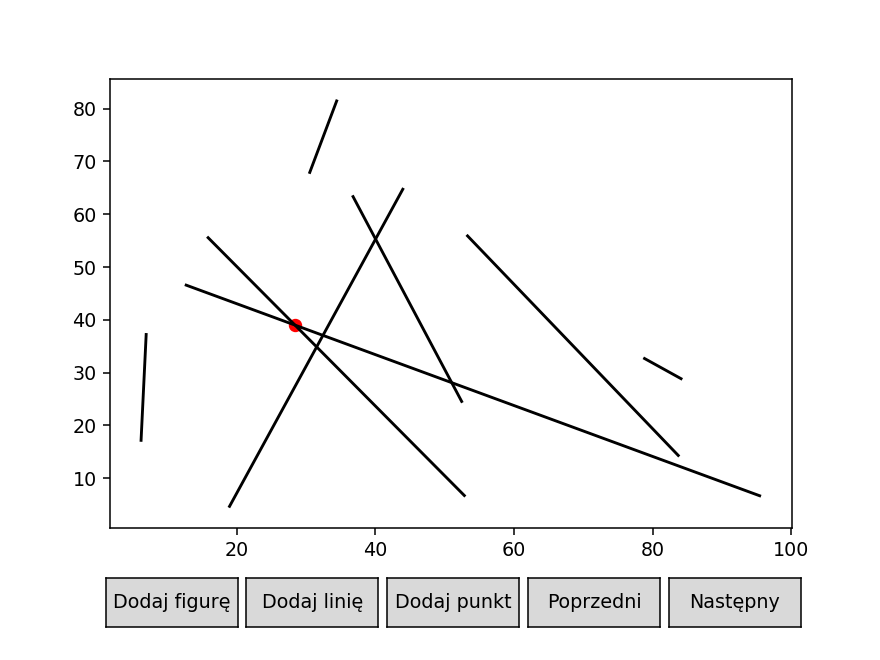

In [24]:
plot=Plot(scenes = sweep(lines,y_range)) #y_range to zakres miotly, by ladnie rysowac
plot.draw() 


In [37]:
#wersja ze znalezieniem wszystkich punktow przeciecia

%matplotlib notebook
#znajdowanie pojedynczego przecięcia

#do przechowywania stuktury zdarzen - kopiec minimum, porzadkowany po x zdarzen-punktow
#do przechowywania struktury odcinkow zamiatanych - uporzadkowany zbior, porzadkujemy po y punktow poczatkowych odcinkow

class SweepStatusAll:
    
    def __init__(self, lines,broom_range):
        self.lines = lines
        self.sweeping_lines = SortedSet(key=lambda line: -line[0])
        self.events = SortedSet(key=lambda x:x[0][0])
        self.scenes = []
        self.result = set() #zapewni nam to przy dodawaniu punktow wielokrotnie tylko jeden egzemplarz w wyniku 
        self.result_lines_set = set()
        self.dict_helper = {}
        self.broom_range = broom_range
        
    def sweepAll(self):
        i = 0
        while len(self.events) > i:
            event = self.events[i]
            self.event_happened(event)
            i+=1
            
    def have_intersection(self,line1,line2):

        #funkcja do sprawdzania czy istnieje przeciecie odcinkow
        #zakladamy, ze odcinki sa aktualnie rozpatrywane, czyli maja jakis wspolny zakres x, w ktorym oba istnieja
        #wystarczy wiec sprawdzac czy oba punkty tworzace odcinek znajduja sie po jednej stronie odcinka drugiego
        
        
        return (orientation(line1[0], line1[1], line2[0]) != orientation(line1[0], line1[1], line2[1])) and (orientation(line2[0], line2[1], line1[0]) != orientation(line2[0], line2[1], line1[1])) 
        
    def get_intersection(self,line1,line2):
        #funckja zwraca wspolrzedne punktu przeciecia
        
        a1 = get_slope(line1)
        b1 = get_y_intercept(line1,a1)
        
        a2 = get_slope(line2)
        b2 = get_y_intercept(line2,a2)     
    
        x = (-(b1-b2))/(a1-a2)
        y = a1*x +b1
        
        return (x,y)
    
    
    #umieszczamy punkty poczatkowe i koncowe kazdej prostej
    #rozrozniamy typ: 1-poczatkowy, -1-koncowy, pozniej tez 0 - 
    def make_events(self):
        for line in self.lines:
            self.events.add((line[0],line,1))
            self.events.add((line[1],line,-1))
            
    
    def event_happened(self,event):
        
        if (event[2] == 1):
            self.add_line(event[1])
        elif (event[2] == -1):
            self.remove_line(event[1])
        else:
            self.cross_point(event)
        self.get_scene(event)
    
    def add_line(self,line):
    #dodajemy do zbioru linii
    
        new_line = (line[0][1],line)
        self.dict_helper[line] = line[0][1]
        self.sweeping_lines.add(new_line)
        
        #aktualizujemy klucze
        self.update_keys(line[0][0])
        
        #sprawdzamy przeciecia z sasiadami
        index = self.sweeping_lines.index((self.dict_helper[line],line)) #odczytujemy index linii
        
        #sasiad gorny to index+1, jezeli istnieje
        if(index+1 < len(self.sweeping_lines)):
            if(self.have_intersection(line,self.sweeping_lines[index+1][1])): #jesli znalezlismy przeciecie to konczymy
                self.add_crossing(line,self.sweeping_lines[index+1][1])
               
        #sasiad dolny index-1
        if(index-1 >= 0):
            if(self.have_intersection(line,self.sweeping_lines[index-1][1])):
                 self.add_crossing(line,self.sweeping_lines[index-1][1])
                    
                    
    def add_crossing(self,line1,line2):
        point = self.get_intersection(line1,line2)
        self.events.add((point,(line1,line2),0)) #dodajemy zdarzenie punktu przeciecia
        if (line1,line2) not in self.result_lines_set and (line2,line1) not in self.result_lines_set:
            self.result.add(point) #dodajemy do wyniku punkt
            self.result_lines_set.add((line1,line2))
        
        
    
    def remove_line(self,line):
        
        index = self.sweeping_lines.index((self.dict_helper[line],line))
        
        #jesli mamy sasiada gornego oraz dolnego sprawdzamy ich przeciecie
        #jesli odcinek byl na brzegu zbioru to brak sasiadow
        
        if not (index == 0 or index == len(self.sweeping_lines)-1):
            if(self.have_intersection(self.sweeping_lines[index-1][1],self.sweeping_lines[index+1][1])):
                self.add_crossing(self.sweeping_lines[index+1][1],self.sweeping_lines[index-1][1])
               
        #usuwamy linie ze zbioru skoro trafilismy na jej koniec
        self.update_keys(line[1][0])
        self.sweeping_lines.remove((self.dict_helper[line],line))
        
    
    def cross_point(self,event):

        point = event[0]
        line1 = event[1][0]
        line2 = event[1][1]        
        
        index1 = self.sweeping_lines.index((self.dict_helper[line1],line1))
        index2 = self.sweeping_lines.index((self.dict_helper[line2],line2))
        
        a1 = get_slope(line1)
        b1 = get_y_intercept(line1,a1)
        
        a2 = get_slope(line2)
        b2 = get_y_intercept(line2,a2)
        
        #usuwamy stare dane
        del self.dict_helper[line1]
        del self.dict_helper[line2]
        
        if(a1 > a2): 
            neighbour1 = index1+1
            neighbour2 = index2-1
            new_y = a1*(point[0]) + b1
        else:
            neighbour1 = index1-1
            neighbour2 = index2+1
            new_y = a1*(point[0]) + b1
            
        
        #wstawiamy nowe dane, w zbiorze sa odcinki poukladane wg nowych wartosci zaraz po przecieciu
        self.dict_helper[line1] = new_y
        self.dict_helper[line2] = new_y
        
        #sprawdzam nowego sasiada linii1 - jezeli istnieje:
        if neighbour2 >= 0 and neighbour2 < len(self.sweeping_lines):
            if (self.have_intersection(line1,self.sweeping_lines[neighbour2][1])):
                self.add_crossing(line1,self.sweeping_lines[neighbour2][1])
        
        if neighbour1 >= 0 and neighbour1 < len(self.sweeping_lines):
            if(self.have_intersection(line2,self.sweeping_lines[neighbour1][1])):
                self.add_crossing(line2,self.sweeping_lines[neighbour1][1])
    
        if(index1 > index2): 
            del self.sweeping_lines[index1]
            del self.sweeping_lines[index2]
        else:
            del self.sweeping_lines[index2]
            del self.sweeping_lines[index1]
            
        if a1 > a2:
            self.sweeping_lines.add((self.dict_helper[line1],line1))
            self.sweeping_lines.add((self.dict_helper[line2],line2))
        else:
            self.sweeping_lines.add((self.dict_helper[line2],line2))
            self.sweeping_lines.add((self.dict_helper[line1],line1))
            
        
    def update_keys(self,x):
        new_sweeping_lines = SortedSet(key=lambda line: -line[0])
        
        for line in self.sweeping_lines:
            new_y = self.update(line[1],x)
            new_sweeping_lines.add((new_y,line[1]))
            self.dict_helper[line[1]] = new_y
        
        self.sweeping_lines = new_sweeping_lines
            
    def update(self,line,x):
        a = get_slope(line)
        b = get_y_intercept(line,a)
        return a*x+b
        
                
    def get_scene(self,event):
        point = event[0]
        broom = [(point[0],self.broom_range[0]),(point[0],self.broom_range[1])]
        
        if(event[2] == 0):
            color_point = 'turquoise'
        elif(event[2] == 1):
            color_point = 'brown'
        else:
            color_point = 'green'
        
        scene = Scene([PointsCollection([point],color=color_point),PointsCollection(list(self.result),color='turquoise')],
                      [LinesCollection(self.lines,color='black'),
                      LinesCollection([broom],color='red')])
                      
        self.scenes.append(scene)
        

        
def sweepAll(lines,broom_range):
    status = SweepStatusAll(lines,broom_range)
    status.make_events()
    status.sweepAll()
    print("Liczba znalezionych punktow: ", len(status.result))
    print(status.result)
    return status.scenes
    


Liczba znalezionych punktow:  5
{(51.00863777508681, 28.084602118763172), (40.01992060931117, 55.294866635833856), (32.42730170136329, 37.04637314983211), (31.517928977506887, 34.860739651189085), (28.39071930622143, 38.99321524072252)}


<IPython.core.display.Javascript object>


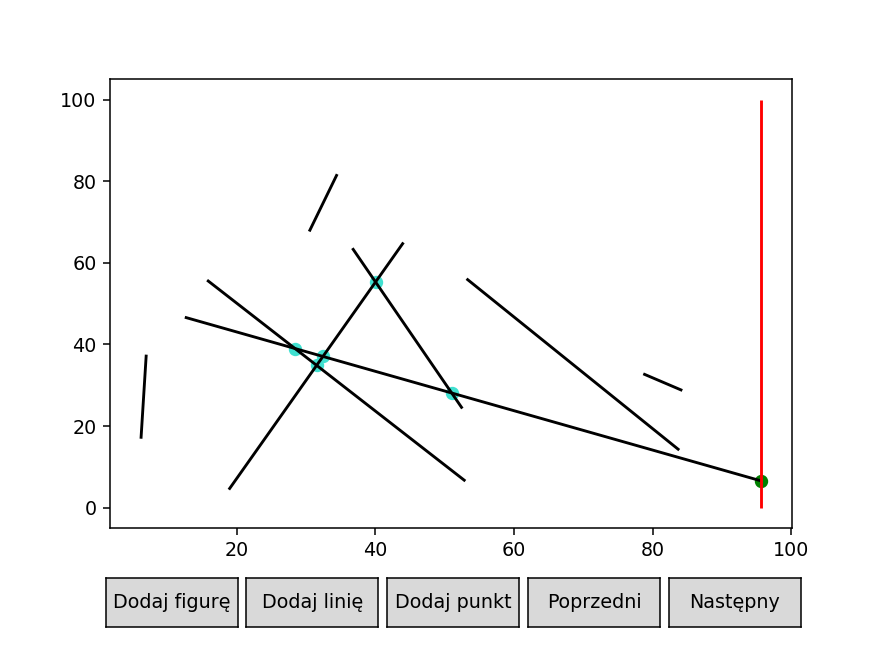

In [38]:
#pelna wizualizacja algorytmu
#punkty brazowe - poczatkowe
#punkty koncowe - zielone
#punkty niebieskie - punkty przeciecia

plot=Plot(scenes = sweepAll(lines,y_range))
plot.draw() 

<IPython.core.display.Javascript object>


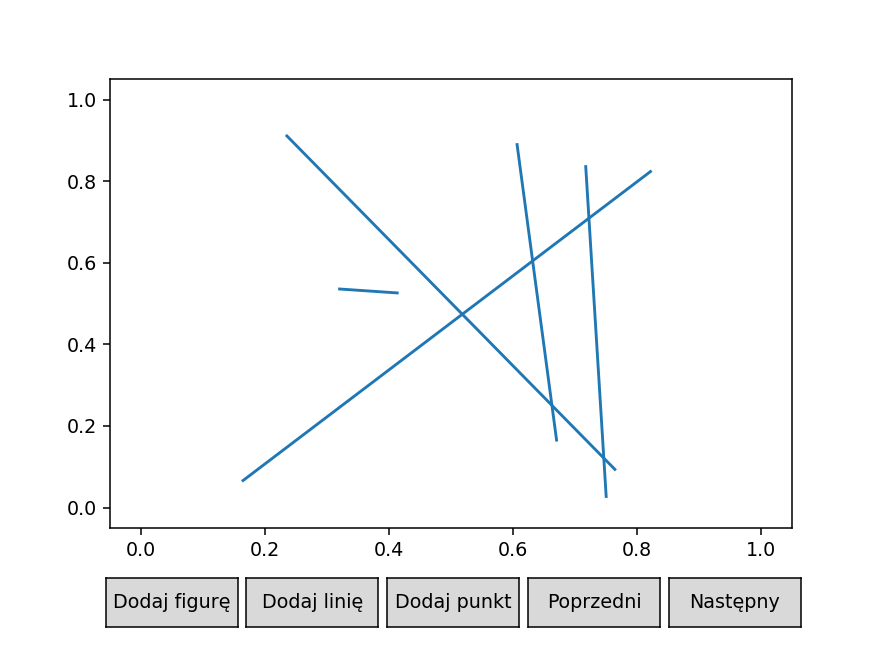

In [39]:
%matplotlib notebook

#TU NALEZY RYSOWAC ODCINKI

#procedura rysowania odcinkow
plottest = Plot()
plottest.draw()

Liczba znalezionych punktow:  5
{(0.7224668022769254, 0.709275156277311), (0.5182206559601746, 0.47389081276251177), (0.7464501539555214, 0.12129115532035684), (0.6316578220617239, 0.6046219592468276), (0.6627983186124252, 0.2505277734852198)}


<IPython.core.display.Javascript object>


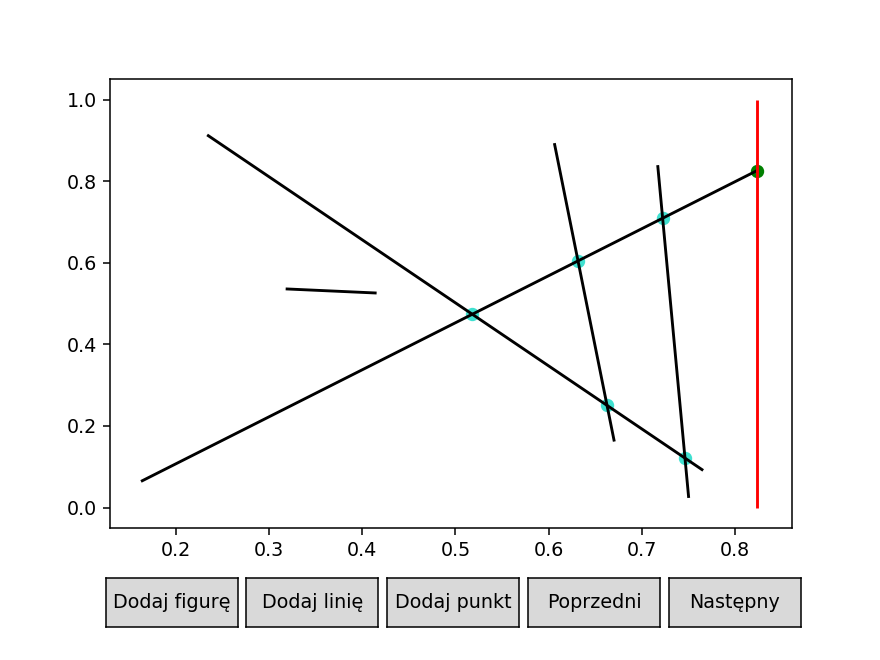

In [40]:
plot2 = Plot([plottest.get_added_elements()])
#sciagamy informacje z narysowanych linii


#ewentualny zapis do pliku: linie.json
#with open('linie.json', 'w') as file:
#    file.write(plot2.toJson())

#with open('linie.json', 'r') as file:
#    json = file.read()
    
#plot3 = Plot(json=json)

lines = getting_lines_from_plot(plottest)
plot=Plot(scenes = sweepAll(lines,[0,1]))
plot.draw() 

Linie sie przecinaja, punkt znaleziony:   (0.4852237835884851, 0.4434369491526206)


<IPython.core.display.Javascript object>


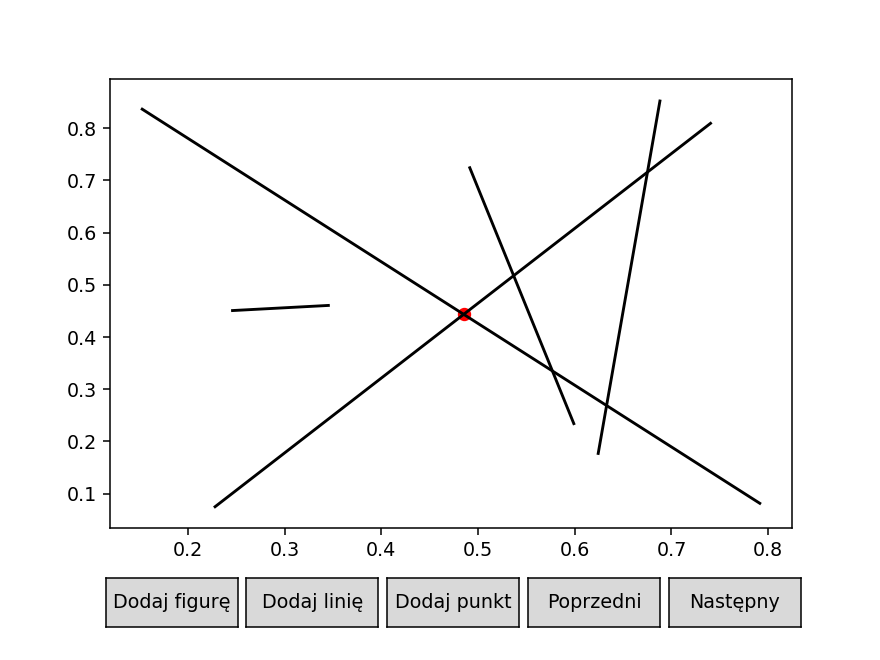

In [310]:
plot=Plot(scenes = sweep(lines,[0,1]))
plot.draw() 

<IPython.core.display.Javascript object>


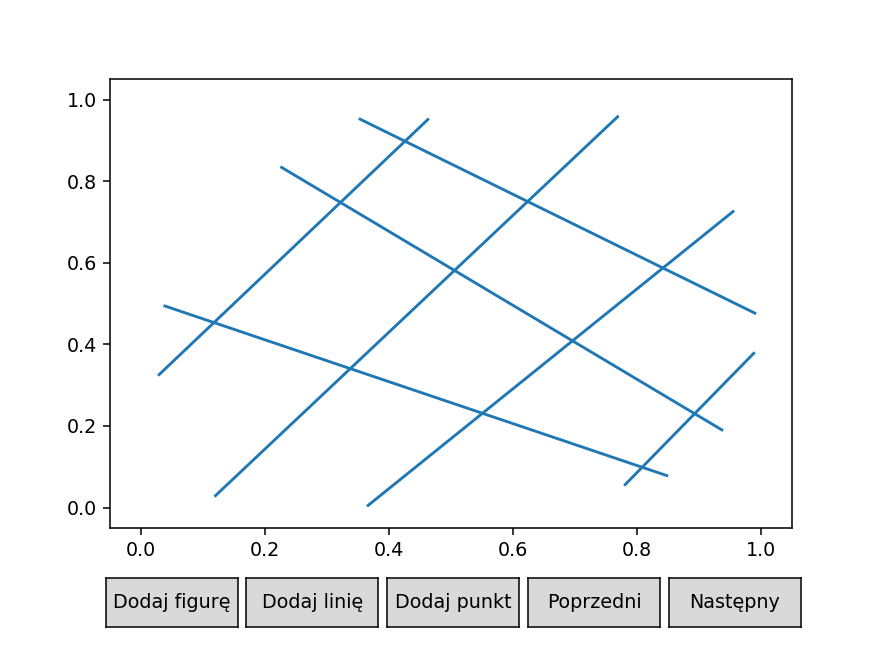

In [41]:
#procedura rysowania odcinkow
plottest = Plot()
plottest.draw()



Liczba znalezionych punktow:  11
{(0.3375360386627371, 0.3406087810045241), (0.11764802175883848, 0.4535074208745068), (0.3217085997237337, 0.7478587621859675), (0.505600815126766, 0.5812337369029862), (0.4257623827844282, 0.8979532631322314), (0.5507785216267609, 0.23112220402721645), (0.6236267651075392, 0.7502161352764856), (0.6959481876290634, 0.4087596836309005), (0.8418423054532599, 0.587283641789502), (0.8083278488425285, 0.09888685463663416), (0.8929782713373184, 0.2302304152361354)}


<IPython.core.display.Javascript object>


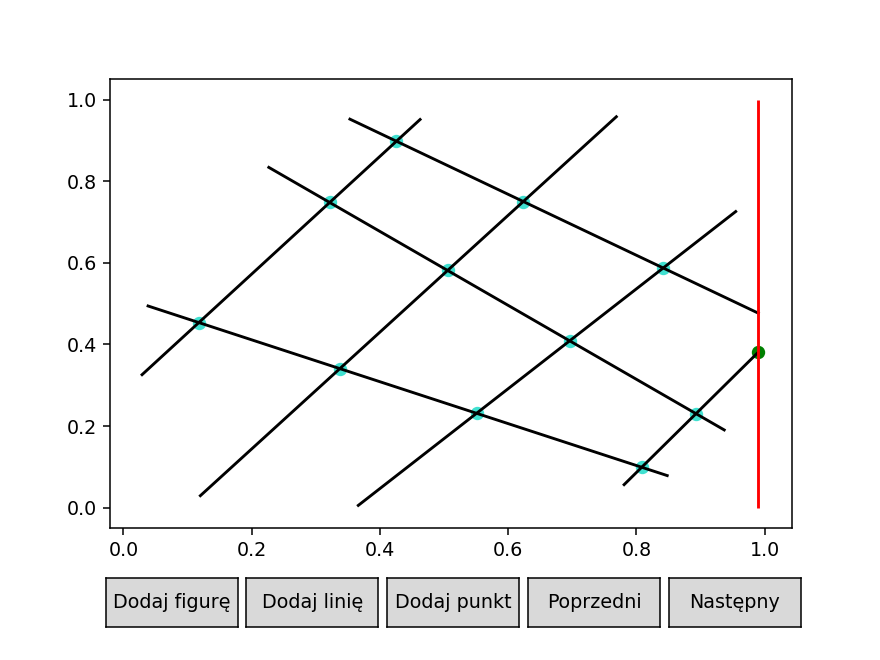

In [42]:
lines = getting_lines_from_plot(plottest)
plot=Plot(scenes = sweepAll(lines,[0,1]))
plot.draw() 